<a href="https://colab.research.google.com/github/FMagnani/ManifoldLearning_scripts/blob/main/mnist_coil20/MNIST_spectral_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laplacian Eigenmap vs fuzzy topological spectral embedding (MNIST)

We want to compare the embedding given by Laplacian Eigenmap with the spectral embedding of the fuzzy topological graph bult by the UMAP algortihm.  
We will use the MNIST and the COIL20 datasets, only partially since I cannot make the Laplacian Eigenmap work with the full datasets (too much computationally expensive I think, even if I have seen people that did it).  


Import MNIST dataset.  


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install idx2numpy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import idx2numpy 
import matplotlib.image as img


train_path = "drive/MyDrive/Benchmark_Datasets/mnist/train-images.idx3-ubyte"
label_path = "drive/MyDrive/Benchmark_Datasets/mnist/train-labels.idx1-ubyte"
         
data_matrix = idx2numpy.convert_from_file(train_path) # shape = (60000, 28, 28)
        
n_samples, dim1, dim2 = data_matrix.shape
vector_dim = dim1*dim2

data = data_matrix.reshape(n_samples, vector_dim) # shape = (60000, 784)
labels = idx2numpy.convert_from_file(label_path)  
        
dataframe = pd.DataFrame(data) # Pandas dataframe, in case it's needed
dataframe["labels"] = labels

# In case it's needed to show the image corresponding to a sample:
def show_sample(sample_number):

        plt.imshow(data_matrix[sample_number], cmap="gray")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Instead of the full dataset, we use only the data corresponding to the digits 0,1,2,3,4, i.e. approximately the half of the dataset.

In [ ]:
dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,labels
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
59996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
59997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
59998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


The following shows how much points we have for each label value.

In [ ]:
dataframe.groupby("labels").count()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,...,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923
1,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,...,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742
2,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,...,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958
3,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,...,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131
4,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,...,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842
5,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,...,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421,5421
6,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,...,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918,5918
7,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,...,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265,6265
8,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,...,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,5851,585

Here the query it's defined and we check that all and only that points have been chosen.

In [ ]:
query = ( dataframe["labels"] < 5 )

dataframe[query].groupby("labels").count()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,...,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923,5923
1,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,...,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742,6742
2,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,...,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958,5958
3,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,...,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131,6131
4,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,...,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842,5842


We finally define our subsample.

In [ ]:
X = dataframe[query][dataframe.columns[:-1]]
labels = dataframe[query]["labels"]

Run a couple of tests in order to estimate the computation time... We use a low number of neaarest neighbors, when increased the computational time will increase too and I don't think linearly.  

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=18d5afcc7f261d832be24129bb25848a48520ba81be7e57960eb13e661b7b068
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=11176498ecd72f8c1b3d11715ee2d9bae0cf36f708340d36b70638e989c927e4
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
from sklearn.manifold import SpectralEmbedding

from umap.umap_ import fuzzy_simplicial_set
from umap.spectral import spectral_layout

In [ ]:

n_neighbors = 15

lapeig_embedding = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

fuztop_graph, _, _, _ = fuzzy_simplicial_set(
                                                         X,
                                                         n_neighbors = n_neighbors,
                                                         random_state = 123456,
                                                         metric = 'euclidean',
                                                         metric_kwds={},
                                                         knn_indices=None,
                                                         knn_dists=None,
                                                         angular=False,
                                                         set_op_mix_ratio=1.0,
                                                         local_connectivity=1.0,
                                                         apply_set_operations=True,
                                                         verbose=False,
                                                         return_dists=False,
                                                        )

fuztop_embedding = spectral_layout(X, fuztop_graph, dim=2,
                                     random_state=123456, metric='euclidean', metric_kwds={})

# Run time (almost entirely taken by Laplacian Eigenmap): 30 minutes
# That's too much.


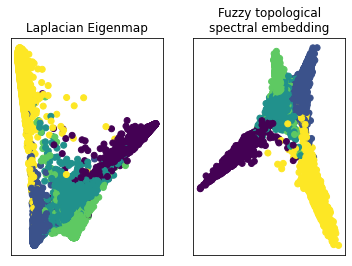

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(lapeig_embedding[:,0], lapeig_embedding[:,1], c=labels)
ax[1].scatter(fuztop_embedding[:,0], fuztop_embedding[:,1], c=labels)

ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])

ax[0].set_title("Laplacian Eigenmap")
ax[1].set_title("Fuzzy topological\nspectral embedding")

fig.show()

In [ ]:
import pandas as pd

In [ ]:
embedding = pd.DataFrame()
embedding["Labels"] = labels
embedding["FuzTop_x"] = fuztop_embedding[:,0]
embedding["FuzTop_y"] = fuztop_embedding[:,1]
embedding["LapEig_x"] = lapeig_embedding[:,0]
embedding["LapEig_y"] = lapeig_embedding[:,1]

embedding.to_csv("half_mnist_embedding")


So we try to emply just four digits out of ten and moreover to reduce by half the datapoints for each class.

In [ ]:
query = ( dataframe["labels"] < 4 )

subsample = len(dataframe[query].index)*0.6 #60% of the data, approximatively
query_2 = ( dataframe.index < subsample )

dataframe[query & query_2]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,labels
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
14849,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
X = dataframe[query & query_2][ dataframe.columns[:-1] ]
labels = dataframe[query & query_2]["labels"]

In [ ]:

n_neighbors = 15

lapeig_embedding = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

fuztop_graph, _, _, _ = fuzzy_simplicial_set(
                                                         X,
                                                         n_neighbors = n_neighbors,
                                                         random_state = 123456,
                                                         metric = 'euclidean',
                                                         metric_kwds={},
                                                         knn_indices=None,
                                                         knn_dists=None,
                                                         angular=False,
                                                         set_op_mix_ratio=1.0,
                                                         local_connectivity=1.0,
                                                         apply_set_operations=True,
                                                         verbose=False,
                                                         return_dists=False,
                                                        )

fuztop_embedding = spectral_layout(X, fuztop_graph, dim=2,
                                     random_state=123456, metric='euclidean', metric_kwds={})

# Run time (almost entirely taken by Laplacian Eigenmap): 1 minute
# That's OK.


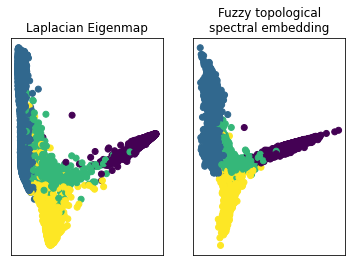

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(lapeig_embedding[:,0], lapeig_embedding[:,1], c=labels)
ax[1].scatter(fuztop_embedding[:,0], fuztop_embedding[:,1], c=labels)

ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])

ax[0].set_title("Laplacian Eigenmap")
ax[1].set_title("Fuzzy topological\nspectral embedding")

fig.show()

In [ ]:
query = ( dataframe["labels"] < 5 )

subsample = len(dataframe[query].index)*0.6 #60% of the data, approximatively
query_2 = ( dataframe.index < subsample )

dataframe[query & query_2]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,labels
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
18345,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
18352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
X = dataframe[query & query_2][ dataframe.columns[:-1] ]
labels = dataframe[query & query_2]["labels"]

In [ ]:

n_neighbors = 15

lapeig_embedding = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

fuztop_graph, _, _, _ = fuzzy_simplicial_set(
                                                         X,
                                                         n_neighbors = n_neighbors,
                                                         random_state = 123456,
                                                         metric = 'euclidean',
                                                         metric_kwds={},
                                                         knn_indices=None,
                                                         knn_dists=None,
                                                         angular=False,
                                                         set_op_mix_ratio=1.0,
                                                         local_connectivity=1.0,
                                                         apply_set_operations=True,
                                                         verbose=False,
                                                         return_dists=False,
                                                        )

fuztop_embedding = spectral_layout(X, fuztop_graph, dim=2,
                                     random_state=123456, metric='euclidean', metric_kwds={})

# Run time (almost entirely taken by Laplacian Eigenmap): 3 minute
# That's very good. I choose this setting.


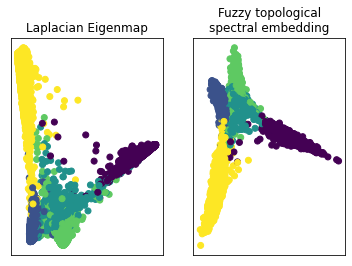

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(lapeig_embedding[:,0], lapeig_embedding[:,1], c=labels)
ax[1].scatter(fuztop_embedding[:,0], fuztop_embedding[:,1], c=labels)

ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])

ax[0].set_title("Laplacian Eigenmap")
ax[1].set_title("Fuzzy topological\nspectral embedding")

fig.show()

It's perfect, we can see the differences without having a lot of time to wait. Let's create the full data now.

In [ ]:
n_neighbors_list = [8, 20, 50]

emb = pd.DataFrame()
emb["Labels"] = labels

for n_neighbors in n_neighbors_list:

  lapeig_embedding = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

  fuztop_graph, _, _, _ = fuzzy_simplicial_set(X,
                                               n_neighbors = n_neighbors,
                                               random_state = 123456,
                                               metric = 'euclidean',
                                               metric_kwds={},
                                               knn_indices=None,
                                               knn_dists=None,
                                               angular=False,
                                               set_op_mix_ratio=1.0,
                                               local_connectivity=1.0,
                                               apply_set_operations=True,
                                               verbose=False,
                                               return_dists=False,
                                              )

  fuztop_embedding = spectral_layout(X, fuztop_graph, dim=2,
                                     random_state=123456, metric='euclidean', metric_kwds={})

  emb[ "FuzTop_x_"+str(n_neighbors) ] = fuztop_embedding[:,0]
  emb[ "FuzTop_y_"+str(n_neighbors) ] = fuztop_embedding[:,1]
  emb[ "LapEig_x_"+str(n_neighbors) ] = lapeig_embedding[:,0]
  emb[ "LapEig_y_"+str(n_neighbors) ] = lapeig_embedding[:,1]




In [ ]:
emb.to_csv("4digit_mnist_embedding.csv")

Check that the csv has been filled correctly.

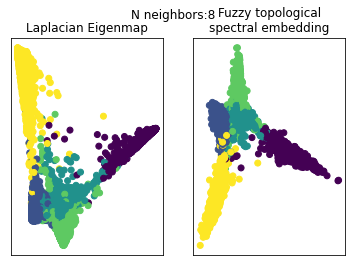

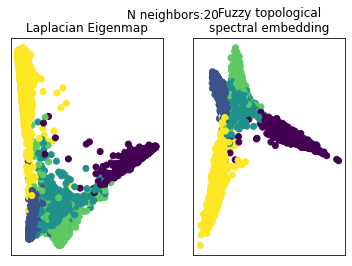

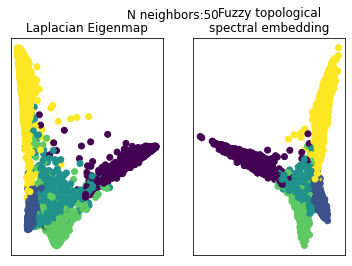

In [ ]:
for n_neighbors in n_neighbors_list:

  fig, ax = plt.subplots(1,2)

  ax[0].scatter(emb["LapEig_x_"+str(n_neighbors)], emb["LapEig_y_"+str(n_neighbors)], c=emb["Labels"])
  ax[1].scatter(emb["FuzTop_x_"+str(n_neighbors)], emb["FuzTop_y_"+str(n_neighbors)], c=emb["Labels"])

  ax[0].get_xaxis().set_ticks([])
  ax[0].get_yaxis().set_ticks([])
  ax[1].get_xaxis().set_ticks([])
  ax[1].get_yaxis().set_ticks([])

  fig.suptitle("N neighbors:"+str(n_neighbors))
  ax[0].set_title("Laplacian Eigenmap")
  ax[1].set_title("Fuzzy topological\nspectral embedding")

  fig.show()